# ``photutils`` SExtractor Background

In this tutorial, I will demonstrate the usage of SExtractor background estimation. 

## What is SExtractor?
Also called Source Extractor, SEx, SE. 

### Orinially
Currently hosted by [Astromatic](https://www.astromatic.net/), developed by Emmanuel Bertin in 1996 ([original paper](https://ui.adsabs.harvard.edu/abs/1996A%26AS..117..393B/abstract)).

### Functionalities
There are two important parts of SExtractor: 
1. Estimation of the spatially varying background and 
2. Automatic recognition of the sources (i.e., properties including shape, flux, etc).

A general implementation of background estimation in `photutils` ([`photutils.background`](https://photutils.readthedocs.io/en/stable/background.html)) includes SExtractor-like background estimation (**this will be covered in this note**). The second part, source recognition (in `photutils`, it is implemented to [`photutils.segmentation`](https://photutils.readthedocs.io/en/stable/segmentation.html)) is covered in Extended Sources lecture note.

### Documentations
There are two bibles for SExtractor and I link those for you just in case you need to use it for historical reasons: 
1. [Official online manual](https://sextractor.readthedocs.io/en/latest/) // [official PDF manual](https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf) 
    * Note that the reaadthedocs web can be converted to PDF ([here](https://sextractor.readthedocs.io/_/downloads/en/latest/pdf/)).
2. a note called ["Source Extractor for Dummies"](http://astroa.physics.metu.edu.tr/MANUALS/sextractor/Guide2source_extractor.pdf)

### Implementations in Python
In python, there are two widely used versions to mimic SExtractor: 
1. ``photutils`` 
2. [``sep`` (Source Extractor in Python)](https://sep.readthedocs.io/) (the [paper on JOSS](https://joss.theoj.org/papers/10.21105/joss.00058))

The pros and cons of these are clear: ``photutils`` gives you more freedom, but is much slower then ``sep``. ``sep`` uses numpy only and is much faster (see [benchmark](https://github.com/kbarbary/sep/blob/master/bench.py)). However, ``sep`` can only do very basic calculations. I personally use ``sep`` for most works because it's faster.

<details><summary>benchmark (``photutils`` VS ``sep``) results from my Mac</summary>
<p>

```
$ python bench.py
test image shape: (1024, 1024)
test image dtype: float32
measure background:  12.34 ms
subtract background:   3.38 ms
background array:   6.94 ms
rms array:   5.21 ms
extract:  88.87 ms  [1167 objects]

sep version:       1.10.0
photutils version: 0.7.1

| test                    | sep             | photutils       | ratio  |
|-------------------------|-----------------|-----------------|--------|
| 1024^2 image background |        11.68 ms |       851.76 ms |  72.94 |
| circles  r= 5  subpix=5 |    3.40 us/aper |   45.30 us/aper |  13.31 |
| circles  r= 5  exact    |    3.89 us/aper |   45.76 us/aper |  11.76 |
| ellipses r= 5  subpix=5 |    3.89 us/aper |   75.29 us/aper |  19.37 |
| ellipses r= 5  exact    |   10.88 us/aper |   63.71 us/aper |   5.85 |
```

</p>
</details>


## SExtractor Algorithm

Basic algorithm is explained in [this section](https://photutils.readthedocs.io/en/stable/background.html) of the ``photutils`` documentation (as well as the SExtractor documentations linked above). SExtractor background estimation is done like this:

1. Chop image into a low-resolution image 
  * In case of the axis length is **not** an integer multiple of corresponding `box_size`, you have to specify the option (`edge_method`). But it is highly recommended not to make such situation, so set `box_size` carefully.

2. For each box ("pad") having `box_size`, do a median filtering with given filter size.
  * The median filter will use `numpy.nan` for "outside-pad" pixels. FYI, the [`photutils.Background2D` source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/background/background_2d.html#Background2D) uses [`scipy.ndimage.generic_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html#scipy.ndimage.generic_filter), and has the following code:
```python
self.background_mesh = generic_filter(
        self.background_mesh, nanmedian_func, size=self.filter_size,
        mode='constant', cval=np.nan)
```

3. Do the sigma-clipping based on `sigma_clip` to each of the pixel within the box after this median filtering.
  * The clipping is done from *median*, not from *mean*.
  
4. For the low-resolution image, do an interpolation to make a background map (size identical to the original image)
  * By default, 3rd order spline fitting is used (as SExtractor default). In `photutils`, it is called [`BkgZoomInterpolator`](https://photutils.readthedocs.io/en/stable/api/photutils.background.BkgZoomInterpolator.html#photutils.background.BkgZoomInterpolator)
  * Unlike median filtering, it has `cval=0.0`, so the values outside the range of interpolation is considered as zero-valued pads.
  * To change this, use the parameter `interpolator`.
  
5. You may need some uncertainty map for the background estimation uncertainty, which is done by tuning the paramter `bkgrms_estimator`. It has the input [`StdBackgroundRMS`](https://photutils.readthedocs.io/en/stable/api/photutils.background.StdBackgroundRMS.html#photutils.background.StdBackgroundRMS) by default. This just calculates the sample standard deviation of the sigma-clipped data within each pad, and takes it as the pad's background estimation RMS (roughly equal to what we call "uncertainty"). Then this low-resolution error map is also interpolated by the same way as the background value map.

Here, the low-resolutioned image (and sometimes the "tile" or pixel of this low-res image) is called *background mesh*, *pad*, or *box*.
  
### A Detailed Explanation
For example, say the image was 1000 by 1000 pixel, and you set ``box_size = (50, 25)``. Then a low-resolution image consists of 20 by 40 "pads" or "meshes" will be made. Each pad will of course have size of 50 by 25. 

If ``filter_size = 3`` (eqauivalent to use ``filter_size = (3, 3)``), a 3 by 3 median filter will be used to reduce sharp noised pixels at each pad. After the median filtering of a pad, the image size is still 50 by 25. 

Within *each* of this median-filtered pad, a sigma-clipping is performed. If too many pixels inside a pad is rejected, that pad is rejected for background estimation. By default, [``photutils.Background2D``](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html) takes ``exclude_mesh_percentile=10``, which means the pad with more than 10% of pixels are rejected will be rejected. 

Then the representative background value from each pad (which has already been median filtered and sigma-clipped) by the following algorithm:

1. Use ``2.5 * median - 1.5 mean`` of each pad.
2. If ``(mean - median) / std > 0.3``, use ``median``.
 
This is done by [``SExtractorBackground``](https://photutils.readthedocs.io/en/stable/api/photutils.background.SExtractorBackground.html#photutils.background.SExtractorBackground) in ``photutils``. Of course there are other options. Check the list of [API](https://photutils.readthedocs.io/en/stable/background.html#module-photutils.background). N.B.: SExtractor user manual has a typo at page 17, ``photutils`` mentions ([link](https://photutils.readthedocs.io/en/stable/api/photutils.background.SExtractorBackground.html#photutils.background.SExtractorBackground)).
  
Once the sky value is set for each pad, it does spline fitting of order 3 to the low-resolution map, i.e., the 20 by 40 image. Then by this fitting, the sky value is given to each of the pixel, i.e., the "sky map" of 1000 by 1000 pixel.

For the sky value at each pixel, we should have some uncertainty. As a rule-of-thumb, the standard deviation of the median filtered and sigma-clipped image is used. For each pad, this value is saved as a representative error, so we have 20 by 40 error map. The 3rd order spline fitting is also done for this error map. Then we finally have the "sky error map" of 1000 by 1000 pixel.

* **TIP**: If you are familiar with the ``photutils`` code, you may wonder what will happen if you put ``sigma_clip`` to the ``Background2D`` and the ``SExtractorBackground``. The ``bkg_estimator`` part of this [``Background2D`` document](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D) says the sigma clipping parameter from `SExtractorBackground` will be ignored.

## Sky Estimation Example by ``photutils``

In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'

In [2]:
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import CircularAperture as CAp
from photutils.centroids import centroid_com
from photutils import Background2D, MedianBackground, SExtractorBackground

import sep

from astropy.visualization import ZScaleInterval, ImageNormalize

def colorbaring(fig, ax, im):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_xticklabels(cb.get_ticks().astype(int), rotation=45)

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)

FIGPATH = Path("figs")
DATAPATH = Path("../../Tutorial_Data")
fpath = DATAPATH/"SNUO_STX16803-kw4-4-4-20190602-135247-R-60.0_bdfw.fits"

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})
rcParams.update({'mathtext.fontset':'dejavuserif'})

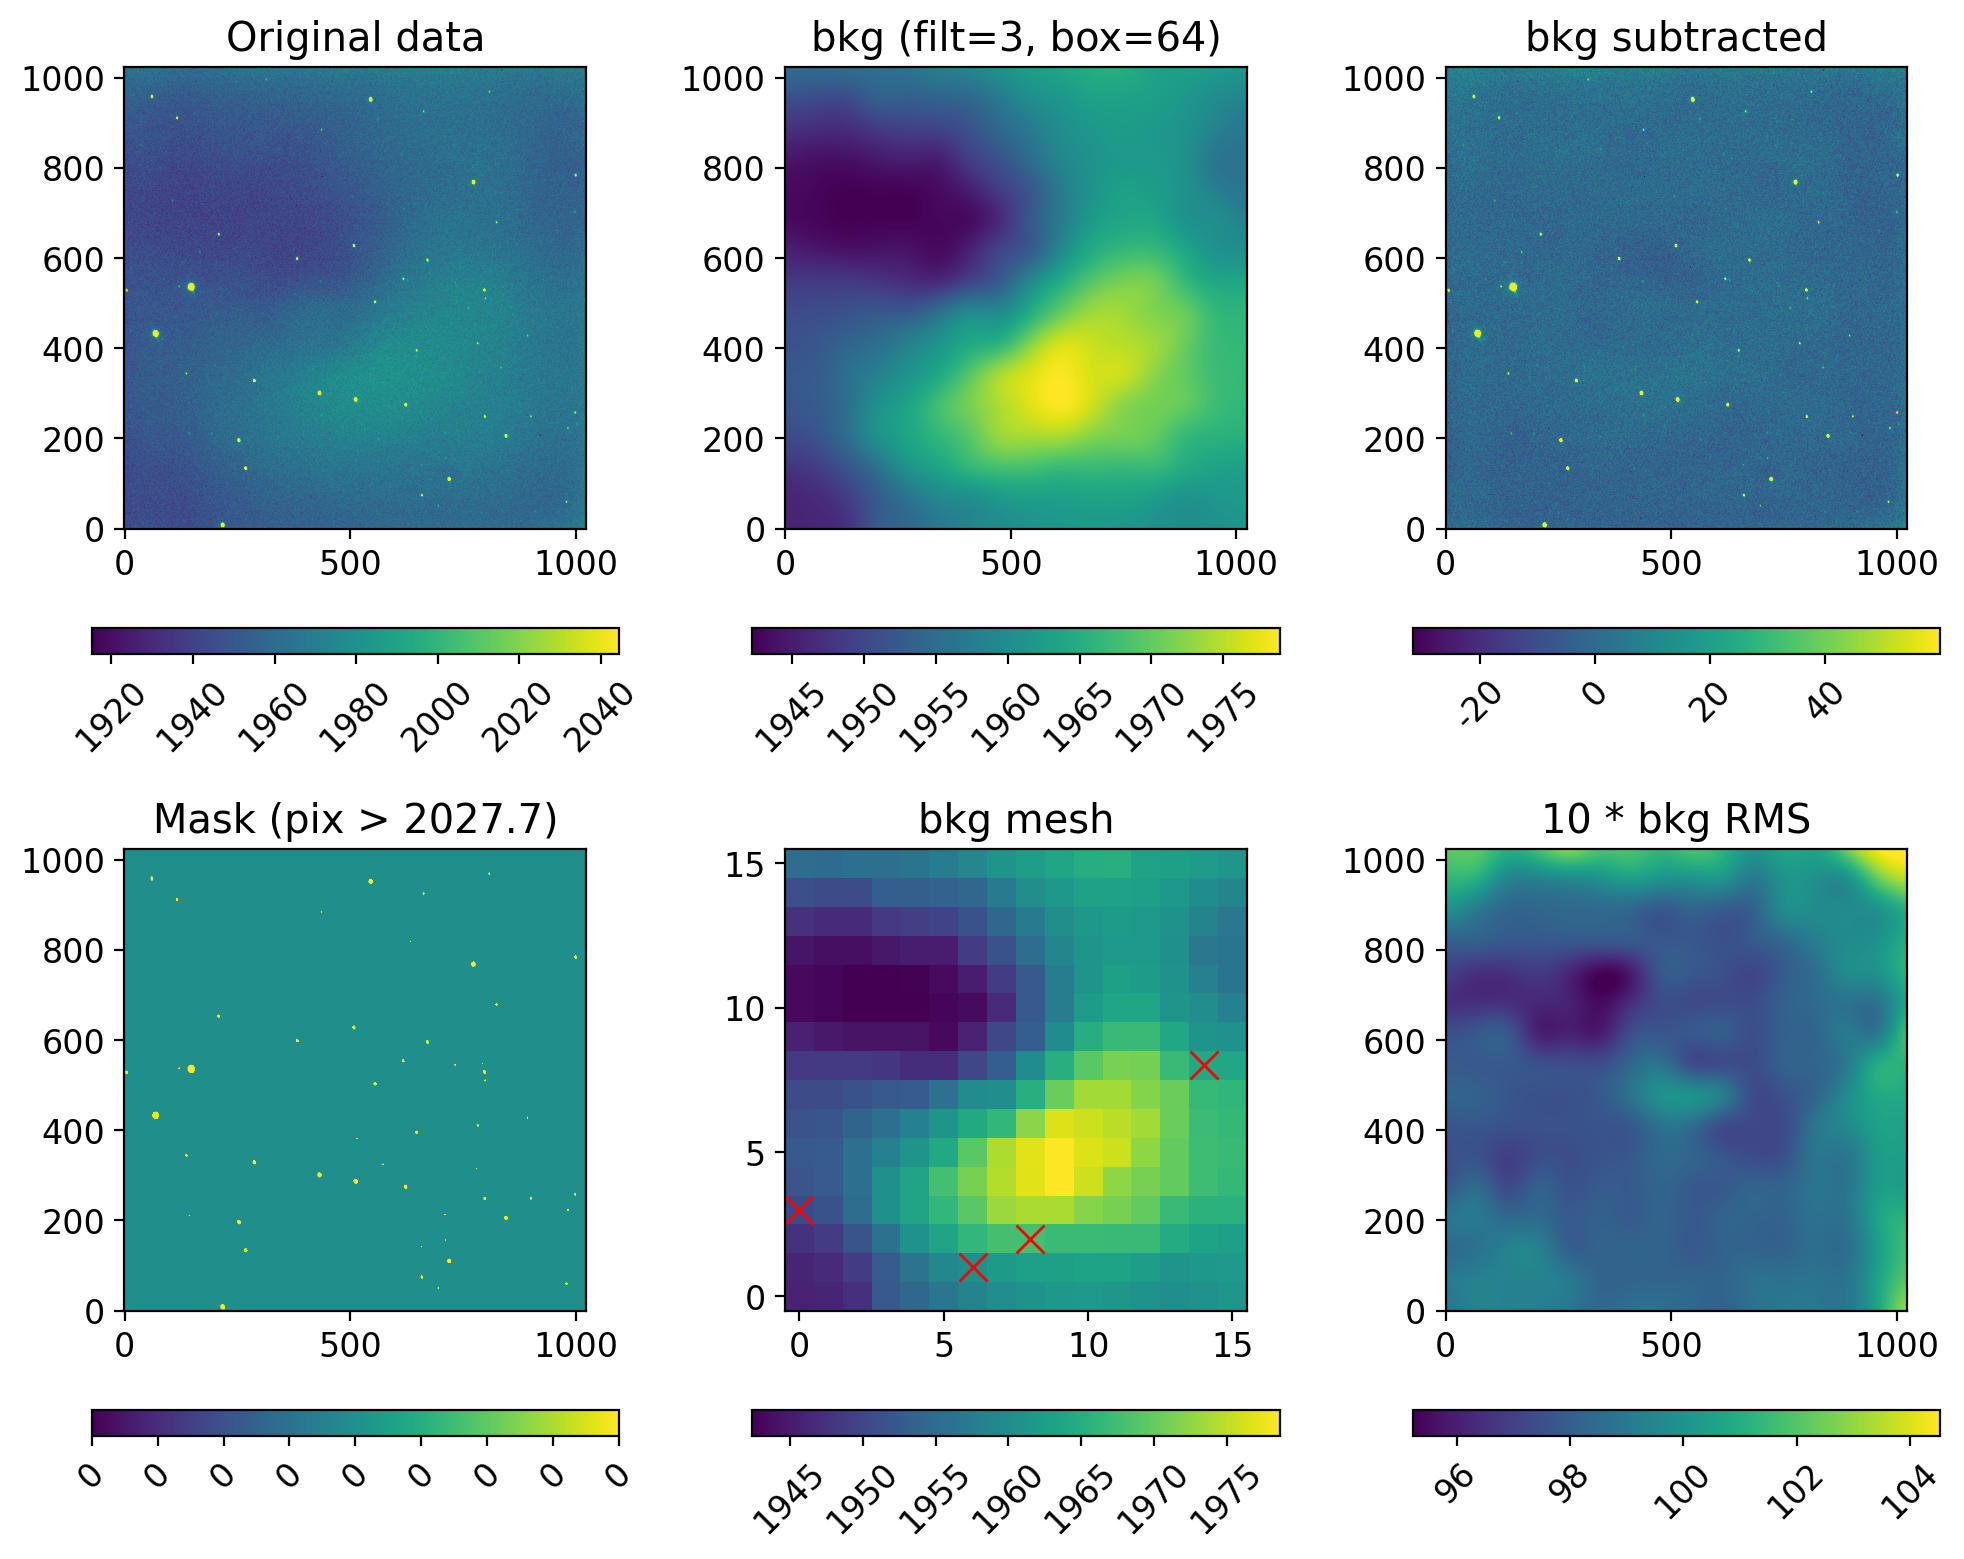

In [4]:
box = 64
filt = 3

bkg_path = fpath.parent / (fpath.name[:-5] + '_bkg.png')
png_path = fpath.parent / (fpath.name[:-5] + '.png')
hdu = fits.open(fpath)[0]
data = hdu.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5)
thresh = med + 5 * std
mask = (data > thresh)  # mask = True when pixel has high signal (possibly a celestial object)

bkg_sex = Background2D(
    data, 
    box_size=box, 
    mask=mask,
    filter_size=filt, 
    exclude_percentile=2,
    sigma_clip=SigmaClip(sigma=3, maxiters=5, cenfunc='median', stdfunc='std')
)
bkgsub_sex = data - bkg_sex.background

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

data2plot = [
    dict(ax=axs[0, 0], arr=data,                      title="Original data"),
    dict(ax=axs[0, 1], arr=bkg_sex.background,        title=f"bkg (filt={filt:d}, box={box:d})"),
    dict(ax=axs[0, 2], arr=bkgsub_sex,                    title="bkg subtracted"),
    dict(ax=axs[1, 0], arr=mask,                      title=f"Mask (pix > {thresh:.1f})"),
    dict(ax=axs[1, 1], arr=bkg_sex.background_mesh,   title="bkg mesh"),
    dict(ax=axs[1, 2], arr=10*bkg_sex.background_rms, title="10 * bkg RMS")
]

for dd in data2plot:
    im = zimshow(dd['ax'], dd['arr'])
    colorbaring(fig, dd['ax'], im)
    dd['ax'].set_title(dd['title'])

try:
    axs[1, 1].plot(*np.where(bkg_sex.background_mesh_ma.mask==True), 'rx', ms=10)
except AttributeError:
    print("No mesh (pad) is masked ")



plt.tight_layout()
plt.savefig(FIGPATH / "sex_bkg_01.png", bbox_inches='tight')

Figure: *Top left* is the original image. *Top center* is the estimated background (note the color-bar scale are different). This is the result of the ``BkgZoomInterpolator`` for the bottom center image. *Top right* is the image after the background subtraction. *Bottom left* shows the masked pixels by the 5-sigma threshold (see code). These masked (yellow) pixels are not used for sigma-clippin in the corresponding mesh (pad). *Bottom center* shows the low-resolution background mesh. Red cross shows the mesh that are **not** used for background estimation because too many pixels are removed from sigma-clipping (highly noisy meshes). *Bottom right* shows the RMS (``sqrt(sum(mesh's median - pixel value))``) multiplied by 10. Note the RMS is generally low when sky alues are low (likely Poisson noise). 

In the code above, I used ``exclude_percentile=2`` (which affects the red-crosses in the bottom center image). That is, if more than 2% of the pixels in the mesh (64 x 64 pixels, so 2% of it means 81.92) are sigma-clipped, that mesh is not used in the background estimation interpolation. 

* **QUESTION**: What happens if ``exclude_percentile=10``?
* **QUESTION**: What happens if ``box`` and/or ``filt`` are severely increased? What happens if decreased? Try many combinations of these. 

## Sky Estimation from ``sep``
There are some caveats which may help you when you start doing research using ``sep``: ``sep`` is *picky* when it comes to the input data types. I recommend you to use a short code snippet such as
```python
kw = dict(mask=mask, bw=bw, bh=bh, fw=fw, fh=fh,
          maskthresh=maskthresh, fthresh=filter_threshold)
try:
    bkg = sep.Background(data, **kw)
except ValueError:  # Non-native byte order
    data = data.byteswap().newbyteorder()
    try:
        bkg = sep.Background(data, **kw)
    except ValueError:  # e.g., int16 not supported
        bkg = sep.Background(data.astype('float32'), **kw)
```
(excerpt from [``ysphotutilpy``](https://github.com/ysBach/ysphotutilpy/blob/265b39ae8b3f4e8b93c49b07e07222cbbff67bd7/ysphotutilpy/seputil.py#L287)). Below we have the non-native byte order error, so I put ``.byteswap().newbyteorder()`.

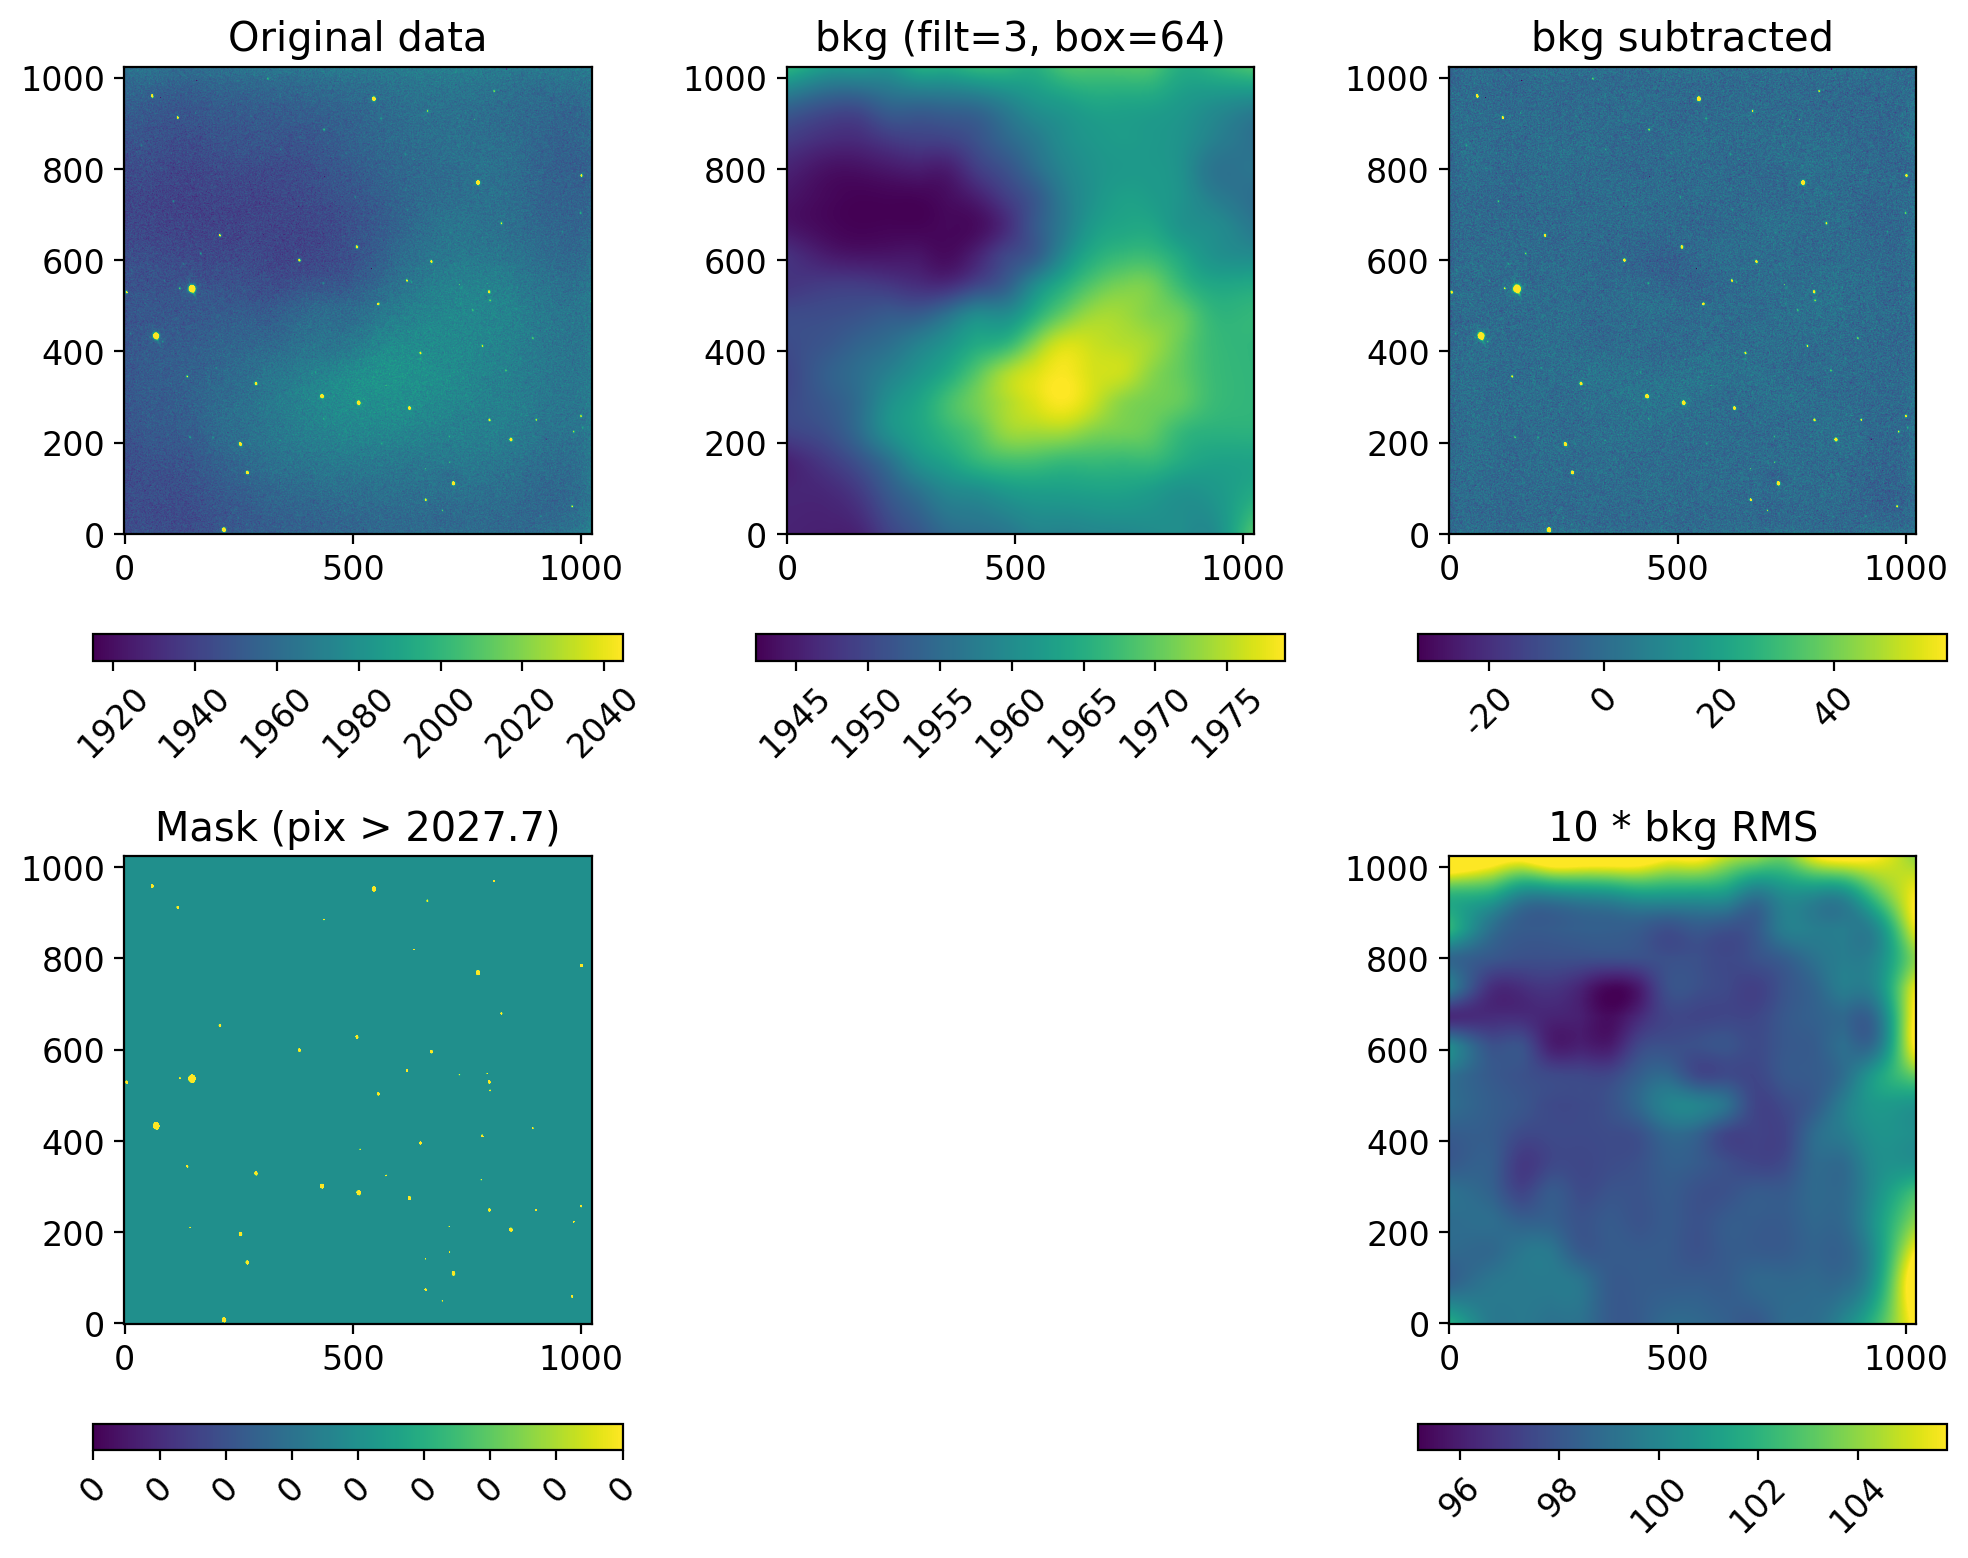

In [5]:
box = 64
filt = 3

bkg_path = fpath.parent / (fpath.name[:-5] + '_bkg_sep.png')
png_path = fpath.parent / (fpath.name[:-5] + '_sep.png')
hdu = fits.open(fpath)[0]
data = hdu.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5)
thresh = med + 5 * std
mask = (data > thresh)  # mask = True when pixel has high signal (possibly a celestial object)

bkg_sep = sep.Background(
    data.byteswap().newbyteorder(), 
    mask=mask, 
    bw=box, bh=box,
    fw=filt, fh=filt
)

bkgsub_sep = data - bkg_sep.back()

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs[1, 1].axis("off")

data2plot = [
    dict(ax=axs[0, 0], arr=data,                      title="Original data"),
    dict(ax=axs[0, 1], arr=bkg_sep.back(),            title=f"bkg (filt={filt:d}, box={box:d})"),
    dict(ax=axs[0, 2], arr=bkgsub_sep,                title="bkg subtracted"),
    dict(ax=axs[1, 0], arr=mask,                      title=f"Mask (pix > {thresh:.1f})"),
#     dict(ax=axs[1, 1], arr=bkg_sep.background_mesh,   title="bkg mesh"),
    dict(ax=axs[1, 2], arr=10*bkg_sep.rms(),          title="10 * bkg RMS")
]

for dd in data2plot:
    im = zimshow(dd['ax'], dd['arr'])
    colorbaring(fig, dd['ax'], im)
    dd['ax'].set_title(dd['title'])


plt.tight_layout()
plt.savefig(FIGPATH / "sex_bkg_01.png", bbox_inches='tight')

Note the bottom center plot is not plotted, because the mesh information is not provided in ``sep``. The difference in background values from the two methods:

Statistics of the difference
           num: 1048576
           min: -11.318954152263586
           max: 4.177406230311817
           avg: 0.13771581401119215
           med: 0.21412505379169033
           std: 1.5258412731760667
   percentiles: [1, 99]
           pct: [-5.82298179  2.81458381]
          zmin: -6.5580907749140644
          zmax: 3.8103918849787988


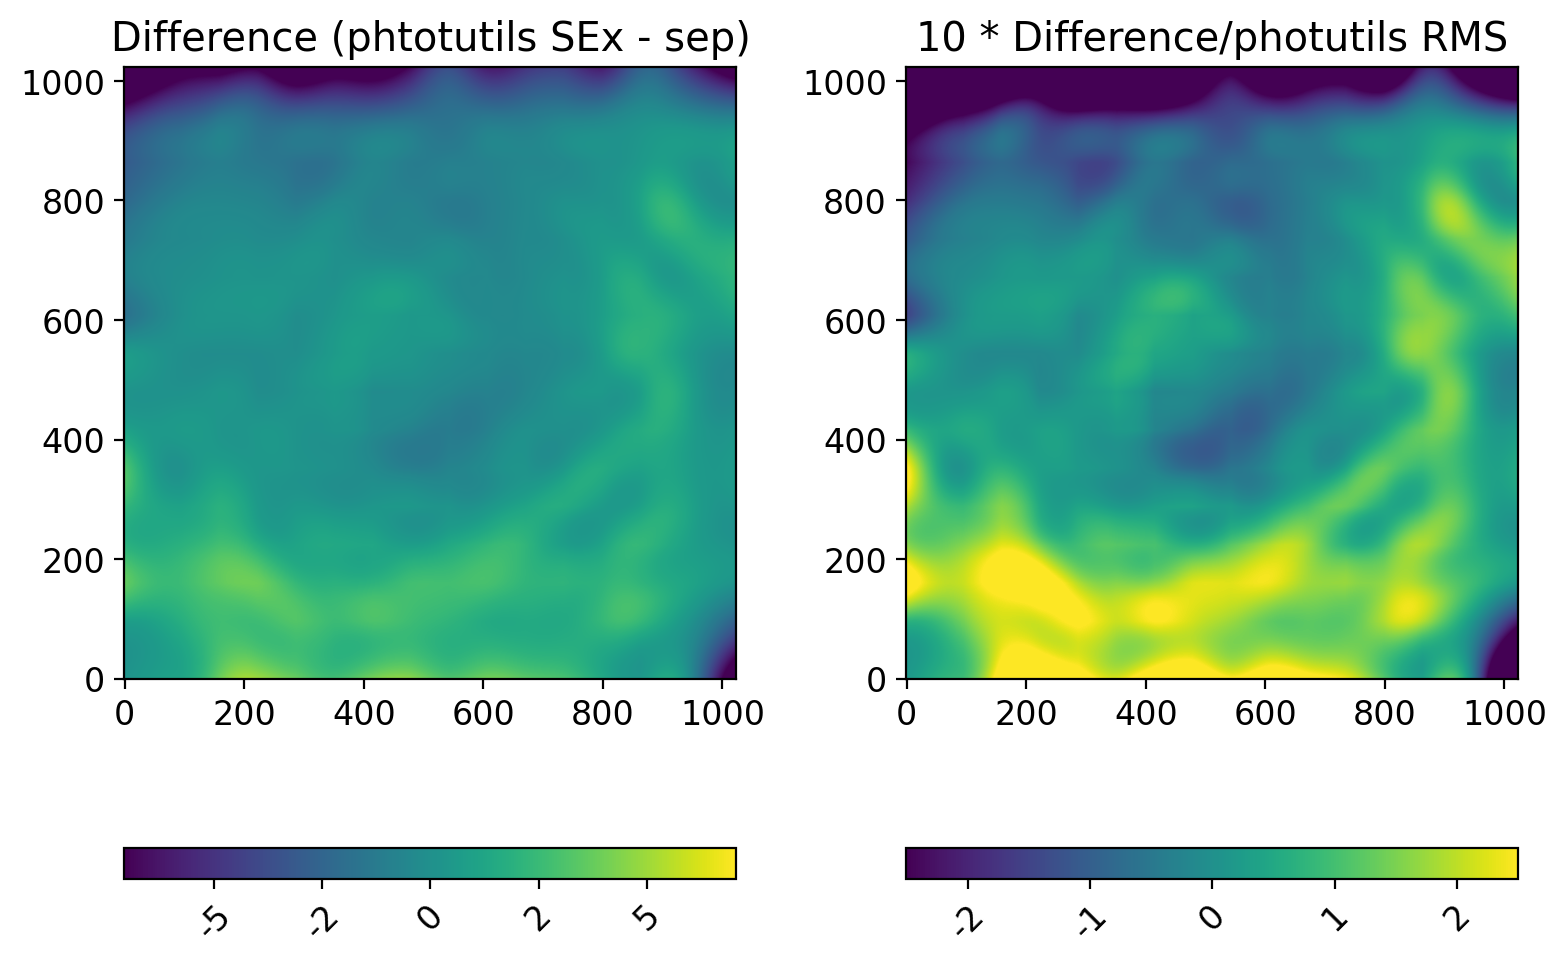

In [6]:
diff = bkg_sex.background - bkg_sep.back()
try:
    import ysfitsutilpy as yfu
    ss = yfu.give_stats(diff)
    print("Statistics of the difference")
    for k, v in ss.items():
        print(f"{k:>14s}: {v}")
except ImportError:
    pass

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

absmax = np.max(np.abs(diff))
im0 = axs[0].imshow(diff, origin='lower', vmin=-absmax/2, vmax=absmax/2)
colorbaring(fig, axs[0], im0)

im1 = axs[1].imshow(10*diff/bkg_sex.background_rms, origin='lower', vmin=-2.5, vmax=2.5)
colorbaring(fig, axs[1], im1)

axs[0].set(title="Difference (phtotutils SEx - sep)")
axs[1].set(title="10 * Difference/photutils RMS")

plt.tight_layout()
plt.show()

# plt.savefig(figoutpath, dpi=300, bbox_inches = "tight")

I am sorry but I have not investigated the reasons for this difference. I just feel safe because these differences in the central part of the FOV is only ~ 0.1 RMS, and outer part is only upto ~ 0.3 RMS (this does not change even if I change the ``exclude_percentile`` to ``10``, the default of ``photutils``).